# Выявление закономерностей, определяющих успешность компьютерных игр

**Заказчик** - интернет-магазин по продаже компьютерных игр.

**Цель** - выявить определяющие успешность игры закономерности (позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании).

**Входные данные** - открытые источники с историческими данными (до 2016 года) о продажах игр, оценки пользователей и критиков, жанры и платформы (Xbox, PlayStation, Wii и т.д.).

**Ход исследования:**
1. Загрузим данные.
2. Изучим данные.
3. Подготовим данные.
4. Исследовательский анализ данных.
5. Портрет пользователя каждого региона (NA, EU, JP):
6. Проверим гипотезы
7. Общий вывод

In [ ]:
!pip install pandas_profiling

In [2]:
import pandas as pd
import numpy as np
import pandas_profiling

from datetime import datetime, timedelta

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from bs4 import BeautifulSoup
import requests
import re

from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

## Загрузим данные.

In [3]:
try:
    df = pd.read_csv('./datasets/games.csv')
    print('Данные загружены локально')
except:
    df = pd.read_csv('https://*********************/games.csv')
    print('Данные загружены с сервера *******************')
df.head()

Данные загружены локально


Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN

In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 5.6 MB


In [5]:
memory_usage_start = 5.6

## Изучим данные.

Описание данных:
- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

*) Данные за 2016 год могут быть неполными.

In [6]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<div class="alert alert-block alert-info"><b>Выводы по разделу:</b>
Требуется провести следующую подготовку данных:
<li>привести названия столбцов к нижнему регистру;
<li>привести значения в столбцах `name`, `platform`, `genre` и `rating` к нижнему регистру;
<li>в столбце `user_score` кроме числовых значений, присутствует значение `tbd` — это сокращение от `To Be Determined` служит для отметки неясностей или пропусков. Таким образом, `tbd` нужно заменить на `NaN`;
<li>привести данные к соответствующим типам;
<li>обработать пропуски в столбцах:
    
    - `name` (2 шт. / < 0.1%);
    - `year_of_release` (269 шт. / 1.6%);
    - `genre` (2 шт. / < 0.1%).

Пропуски в столбцах:
<li>`critic_score` (8578 шт. / 51.3%);
<li>`user_score` (6701 шт. / 40.1%);
<li>`rating` (6766 шт. / 40.5%);

естественны, посольку оценок критиков, пользователей, а также рейтинга может и не быть, поэтому их обрабатывать не нужно.

Дубликаты отсутствуют.<br>
Однако следует <b>перепроверить на дубликаты после подготовки данных</b>.
</div>

## Подготовим данные.
- Приведём названия столбцов к нижнему регистру.
- Приведём значения в столбцах `name`, `platform`, `genre` и `rating` к нижнему регистру.
- Заменим значения `tbd` в столбце `user_score` на `NaN`.
- Приведём данные к соответствующим типам.
- Обработаем пропуски.
- Проверим дубликаты.
- Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

### Приведём названия столбцов к нижнему регистру.

In [7]:
df.rename(str.lower, axis='columns', inplace=True)
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Приведём значения в столбцах `name`, `platform`, `genre` и `rating` к нижнему регистру.

In [8]:
for column in df[['name','platform','genre','rating']]:
    df[column] = df[column].str.lower()

# Test
df.sample(5)

name platform  \
9997                           deception iv: blood ties      ps3   
9770  atelier sophie: the alchemist of the mysteriou...      ps4   
8143                      senran kagura: estival versus      ps4   
6628                                    just dance 2015      ps3   
2317                                      nba live 2005       xb   

      year_of_release         genre  na_sales  eu_sales  jp_sales  \
9997           2014.0        action      0.03      0.02      0.06   
9770           2015.0  role-playing      0.03      0.02      0.06   
8143           2015.0        action      0.08      0.00      0.08   
6628           2014.0          misc      0.13      0.08      0.00   
2317           2004.0        sports      0.81      0.05      0.00   

      other_sales  critic_score user_score rating  
9997         0.01          70.0        8.2      m  
9770         0.01          75.0        8.1    NaN  
8143         0.02          67.0          8      m  
6628         0.04           NaN        6.8   e10+  
2317         0.04          85.0        7.6      e

### Заменим значения `tbd` в столбце `user_score` на `NaN`.

TBD - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). Используется, если какая-то информация еще не определена или решение по вопросу не принято.

In [9]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = np.nan

# Test
df[df['user_score'] == 'tbd']

Empty DataFrame
Columns: [name, platform, year_of_release, genre, na_sales, eu_sales, jp_sales, other_sales, critic_score, user_score, rating]
Index: []

### Приведём данные к соответствующим типам.

In [10]:
# Изучим типы данные и их значения в каждом столбце датасета
display(df.info())
display(df.describe(include='all').T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

count unique                          top  freq  \
name               16713  11559  need for speed: most wanted    12   
platform           16715     31                          ps2  2161   
year_of_release  16446.0    NaN                          NaN   NaN   
genre              16713     12                       action  3369   
na_sales         16715.0    NaN                          NaN   NaN   
eu_sales         16715.0    NaN                          NaN   NaN   
jp_sales         16715.0    NaN                          NaN   NaN   
other_sales      16715.0    NaN                          NaN   NaN   
critic_score      8137.0    NaN                          NaN   NaN   
user_score          7590     95                          7.8   324   
rating              9949      8                            e  3990   

                        mean        std     min     25%     50%     75%  \
name                     NaN        NaN     NaN     NaN     NaN     NaN   
platform                 NaN        NaN     NaN     NaN     NaN     NaN   
year_of_release  2006.484616    5.87705  1980.0  2003.0  2007.0  2010.0   
genre                    NaN        NaN     NaN     NaN     NaN     NaN   
na_sales            0.263377   0.813604     0.0     0.0    0.08    0.24   
eu_sales             0.14506   0.503339     0.0     0.0    0.02    0.11   
jp_sales            0.077617   0.308853     0.0     0.0     0.0    0.04   
other_sales         0.047342   0.186731     0.0     0.0    0.01    0.03   
critic_score       68.967679  13.938165    13.0    60.0    71.0    79.0   
user_score               NaN        NaN     NaN     NaN     NaN     NaN   
rating                   NaN        NaN     NaN     NaN     NaN     NaN   

                    max  
name                NaN  
platform            NaN  
year_of_release  2016.0  
genre               NaN  
na_sales          41.36  
eu_sales          28.96  
jp_sales          10.22  
other_sales       10.57  
critic_score       98.0  
user_score          NaN  
rating              NaN

Посмотрим, какие столбцы могут стать категориального типа: выведем для каждого столбца количество уникальных значений в нём:

In [11]:
pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                                          columns=['column_name', 'num_unique']).sort_values(by=['num_unique'])

column_name  num_unique
10           rating           8
3             genre          12
1          platform          31
2   year_of_release          37
8      critic_score          82
9        user_score          95
7       other_sales         155
6          jp_sales         244
5          eu_sales         307
4          na_sales         402
0              name       11559

Эта таблица помогает определить какие поля можно отнести к категориальным:
- поля `rating`, `genre` и `platform` хорошо подходят для определения их категориальными;
- поле `year_of_release` является годом выпуска игры, т.е. датой и преобразовывать его в категориальные не следует;
- поля `critic_score`, `user_score`, `other_sales`, `jp_sales`, `eu_sales` и `na_sales` по своему смыслу будут полезны именно как числовые поля;
- поле `name` содержит слишком много уникальных значений, поэтому смысла определять его категориальным нет.

Поля датасета:
- `name` — название игры, тип `object` не меняем;
- `platform` — платформа, тип `object` меняем на `category`;
- `year_of_release` — год выпуска, тип `float64` меняем на `datetime64[ns]`, поскольку поле отражает год выпуска;
- `genre` — жанр игры, тип `object` меняем на `category`;
- `na_sales` — продажи в Северной Америке (миллионы проданных копий), тип `float64` меняем на `float32`, поскольку диапазон значений поля мал;
- `eu_sales` — продажи в Европе (миллионы проданных копий), тип `float64` меняем на `float32`, поскольку диапазон значений поля мал;
- `jp_sales` — продажи в Японии (миллионы проданных копий), тип `float64` меняем на `float32`, поскольку диапазон значений поля мал;
- `other_sales` — продажи в других странах (миллионы проданных копий), тип `float64` меняем на `float32`, поскольку диапазон значений поля мал;
- `critic_score` — оценка критиков (максимум 100), тип `float64` меняем на `float32`, поскольку диапазон значений поля мал;
- `user_score` — оценка пользователей (максимум 10), тип `object` меняем на `float32`, поскольку диапазон значений поля мал;
- `rating` — рейтинг от организации `ESRB` (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию, тип `object` меняем на `category`.

In [12]:
columns = ['platform', 'genre', 'rating']
for column in columns:
    df[column] = df[column].astype('category')

df['year_of_release'] = pd.to_datetime(df['year_of_release'], format='%Y', errors='coerce')

columns = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score','user_score']
for column in columns:
    df[column] = df[column].astype('float32')

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             16713 non-null  object        
 1   platform         16715 non-null  category      
 2   year_of_release  16446 non-null  datetime64[ns]
 3   genre            16713 non-null  category      
 4   na_sales         16715 non-null  float32       
 5   eu_sales         16715 non-null  float32       
 6   jp_sales         16715 non-null  float32       
 7   other_sales      16715 non-null  float32       
 8   critic_score     8137 non-null   float32       
 9   user_score       7590 non-null   float32       
 10  rating           9949 non-null   category      
dtypes: category(3), datetime64[ns](1), float32(6), object(1)
memory usage: 1.9 MB


In [13]:
memory_usage_end = 1.9
print(memory_usage_start, '/', memory_usage_end, '=', round((memory_usage_start/memory_usage_end), 2))

5.6 / 1.9 = 2.95


Приведение к нужным типам данных уменьшило необходимый объём оперативной памяти почти в три раза.

### Обработаем пропуски.
Пропуски присутствуют в столбцах:
- `name` (2 шт. / < 0.1%),
- `year_of_release` (269 шт. / 1.6%),
- `genre` (2 шт. / < 0.1%).

#### `name` — название игры

In [14]:
df[df['name'].isna()]

name platform year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      gen      1993-01-01   NaN      1.78      0.53      0.00   
14244  NaN      gen      1993-01-01   NaN      0.00      0.00      0.03   

       other_sales  critic_score  user_score rating  
659           0.08           NaN         NaN    NaN  
14244         0.00           NaN         NaN    NaN

Присутствуют 2 пропущенных значения `NaN`.

Строки 659 и 14244 удалим, поскольку нет критически важной информации ни о названии игры (`name`), ни о её жанре (т.е. одновременно обработаем пропуски в поле `genre`). Кроме того, 2 пропуска составляют менее 0.1% от всего датасета.

Причиной их появления могла оказаться система сбора информации (например, при передаче или конвертации данных или же сбой при записи в `csv` файл).

In [15]:
# Удаляем строки 659 и 14244.
df = df[df['name'].notna()]

# Test
df[df['name'].isna()]

Empty DataFrame
Columns: [name, platform, year_of_release, genre, na_sales, eu_sales, jp_sales, other_sales, critic_score, user_score, rating]
Index: []

#### `year_of_release` — год выпуска

Известно, что данные за 2016 год могут быть неполными.

Посмотрим сколько данных есть за 2016 год:

In [16]:
df[df['year_of_release'] == '2016-01-01']['name'].count()

502

Посмотрим на данные после 2016 года:

In [17]:
df[df['year_of_release'] > '2016-01-01']

Empty DataFrame
Columns: [name, platform, year_of_release, genre, na_sales, eu_sales, jp_sales, other_sales, critic_score, user_score, rating]
Index: []

Данных после 2016 года не полные, а по сути их почти нет, поэтому эти 2 записи можно удалить.

In [18]:
df = df[df['year_of_release'] < '2017-01-01']

# Test
df[df['year_of_release'] > '2016-01-01']

Empty DataFrame
Columns: [name, platform, year_of_release, genre, na_sales, eu_sales, jp_sales, other_sales, critic_score, user_score, rating]
Index: []

Посмотрим на данные с пропусками года выпуска (`year_of_release`):

In [19]:
df[df['year_of_release'].isna()]

Empty DataFrame
Columns: [name, platform, year_of_release, genre, na_sales, eu_sales, jp_sales, other_sales, critic_score, user_score, rating]
Index: []

Присутствуют 269 пропущенных значений (NaN).

По названиям игр, найдём в интернете год выпуска в соответствии с платформой на сайте www.mobygames.com

In [20]:
def platform_and_year(name, platforms_and_years):
    s = platforms_and_years.replace('and','').replace(',','').split()
    dff = pd.DataFrame(columns=['name', 'platform', 'year_of_release'])
    j = 0
    for i, el in enumerate(s):
        year = 0
        try:
            year = int(el[1:5])
            if 1970 < year < 2023:
                platform = ' '.join(s[j:i])
                dff1 = pd.DataFrame(data={'name':name, 'platform':platform, 'year_of_release':year},index=[0])
                dff = pd.concat([dff, dff1])
                j = i+1
        except: pass
    return dff

Поскольку парсинг занимает довольно продолжительное время, то для ускорения проверки готовый результат подтянем с Google Таблиц.

In [21]:
df_mobygames = pd.read_csv('https://docs.google.com/spreadsheets/d/' +
                   '17UoZ_SaOozja2FukjK7P5if_SnuzuIJMJYfx3bCXIIo' +
                   '/export?gid=0&format=csv', index_col=0)
df_mobygames['year_of_release'] = pd.to_datetime(df_mobygames['year_of_release'], format='%Y', errors='coerce')
df_mobygames

name          platform year_of_release
0    madden nfl 2004       playstation      2003-01-01
1    madden nfl 2004  game boy advance      2003-01-01
2    madden nfl 2004          gamecube      2003-01-01
3    madden nfl 2004     playstation 2      2003-01-01
4    madden nfl 2004           windows      2003-01-01
..               ...               ...             ...
744    freaky flyers              xbox      2003-01-01
745        inversion     playstation 3      2012-01-01
746        inversion           windows      2012-01-01
747        inversion          xbox 360      2012-01-01
748        inversion           windows      2021-01-01

[749 rows x 3 columns]

Таблица соответсвия полного названия платформы и сокращённого

In [22]:
df_platform = pd.read_csv('https://docs.google.com/spreadsheets/d/' +
                          '183aEBL7I03xgqdK3c3f7KiIZTHi7Ca9wuiwdCJUYJwk' +
                          '/export?gid=0&format=csv', index_col=0)
df_platform.head(5)

abbreviation                     platform
0         2600                   atari 2600
1          3do  3do interactive multiplayer
2          3ds                 nintendo 3ds
3           dc                    dreamcast
4           ds                  nintendo ds

В `df_mobygames` удалим строки с платформами, которые точно не встречаются в датасете и оставим только сокращённое название платформы.

In [23]:
df_mobygames = df_mobygames.merge(df_platform, how='left', on='platform')
df_mobygames = df_mobygames[df_mobygames['abbreviation'].notna()]
df_mobygames = df_mobygames.drop(columns='platform', axis=1)

df_mobygames

name year_of_release abbreviation
0    madden nfl 2004      2003-01-01           ps
1    madden nfl 2004      2003-01-01          gba
2    madden nfl 2004      2003-01-01           gc
3    madden nfl 2004      2003-01-01          ps2
4    madden nfl 2004      2003-01-01           pc
..               ...             ...          ...
744    freaky flyers      2003-01-01           xb
745        inversion      2012-01-01          ps3
746        inversion      2012-01-01           pc
747        inversion      2012-01-01         x360
748        inversion      2021-01-01           pc

[556 rows x 3 columns]

Датасет `df_mobygames` содержит год выпуска под разные игровые платформы тех игр, о котором эта информация в датасете `df` отсутствует.

Добавим информацуию о годе выпуска, согласно игровой платформе в датасет df:

In [24]:
df = df.merge(df_mobygames, how='left', left_on=['name','platform'], right_on=['name','abbreviation'])
df.loc[df['year_of_release_x'].isna(), 'year_of_release_x'] = df['year_of_release_y']
df = df.drop(columns=['year_of_release_y', 'abbreviation'], axis=1)
df = df.rename(columns={'year_of_release_x':'year_of_release'})

In [25]:
df[df['year_of_release'].isna()].shape[0]

0

Количество пропусков сильно **сократилось с 269 до 67**.

Для некоторых игр дата выпуска указана только для одной платформы, а для других значение даты выпуска пропущено.<br>
Довольно часто игры сразу выпускают для нескольких платформ в один год, но конечно так бывает не всегда.

Заменим недостающие значения годов выпуска минимальным значением по всем платформам в рамках каждой игры в тех случаях, где это возможно (такие данные есть не для всех игр).

In [26]:
names = list(
    df[
        df['name'].isin(
            df[df['year_of_release'].isna()]
            ['name'].unique()
        )
    ]['name'].sort_values().unique()
)

for name in names:
    year = df[df['name'] == name]['year_of_release'].min()
    indx = list(df[df['name'] == name].index)
    for i in indx:
        if df.loc[i,'year_of_release'] is pd.NaT:
            df.loc[i,'year_of_release'] = year

df[df['year_of_release'].isna()].shape[0]

0

Количество пропусков **ещё сократилось до 46**.

In [27]:
# df[df['year_of_release'].isna()]

После обработки ещё раз проверим данные на дубликаты и удалим их:

In [28]:
df[df.duplicated(keep=False)]

name platform year_of_release     genre  na_sales  \
1725   sonic the hedgehog      ps3      2006-01-01  platform      0.41   
1726   sonic the hedgehog      ps3      2006-01-01  platform      0.41   
1805            rocksmith      ps3      2011-01-01      misc      0.53   
1806            rocksmith      ps3      2011-01-01      misc      0.53   
1809            rocksmith     x360      2011-01-01      misc      0.84   
1810            rocksmith     x360      2011-01-01      misc      0.84   
1977   sonic the hedgehog     x360      2006-01-01  platform      0.44   
1978   sonic the hedgehog     x360      2006-01-01  platform      0.44   
11181         bejeweled 3       pc      2010-01-01    puzzle      0.02   
11182         bejeweled 3       pc      2010-01-01    puzzle      0.02   

       eu_sales  jp_sales  other_sales  critic_score  user_score rating  
1725       0.06      0.04         0.66          43.0         4.1   e10+  
1726       0.06      0.04         0.66          43.0         4.1   e10+  
1805       0.36      0.09         0.15          80.0         8.3      t  
1806       0.36      0.09         0.15          80.0         8.3      t  
1809       0.19      0.01         0.08          77.0         8.2      t  
1810       0.19      0.01         0.08          77.0         8.2      t  
1977       0.48      0.00         0.11          46.0         4.4   e10+  
1978       0.48      0.00         0.11          46.0         4.4   e10+  
11181      0.05      0.00         0.01          82.0         8.1      e  
11182      0.05      0.00         0.01          82.0         8.1      e

In [29]:
df = df.drop_duplicates()

# Test
df[df.duplicated(keep=False)]

Empty DataFrame
Columns: [name, platform, year_of_release, genre, na_sales, eu_sales, jp_sales, other_sales, critic_score, user_score, rating]
Index: []

Количество `NaN` в поле `rating`:

In [30]:
df[df['rating'].isna()].shape[0]

6676

In [31]:
df[df['rating']=='rp'].shape[0]

1

`NaN` действительно оч. много.

Ппоскольку значение «RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга, то поменяем значения `NaN` на `rp`.

In [32]:
df.loc[df['rating'].isna(), 'rating'] = 'rp'

In [33]:
# Test
df[df['rating']=='rp'].shape[0]

6677

### Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [34]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.reset_index(drop=True, inplace=True)
df.head()

name platform year_of_release         genre   na_sales  \
0                wii sports      wii      2006-01-01        sports  41.360001   
1         super mario bros.      nes      1985-01-01      platform  29.080000   
2            mario kart wii      wii      2008-01-01        racing  15.680000   
3         wii sports resort      wii      2009-01-01        sports  15.610000   
4  pokemon red/pokemon blue       gb      1996-01-01  role-playing  11.270000   

    eu_sales  jp_sales  other_sales  critic_score  user_score rating  \
0  28.959999      3.77         8.45          76.0         8.0      e   
1   3.580000      6.81         0.77           NaN         NaN     rp   
2  12.760000      3.79         3.29          82.0         8.3      e   
3  10.930000      3.28         2.95          80.0         8.0      e   
4   8.890000     10.22         1.00           NaN         NaN     rp   

   total_sales  
0    82.539993  
1    40.240002  
2    35.520000  
3    32.770000  
4    31.380001

<div class="alert alert-block alert-info"><b>Выводы по разделу:</b>
    
Проведена подготовка данных: названия столбцов и значения в некоторых столбцах приведены к нижнему регистру, значения tbd заменены на NaN, данные приведены к соответствующим типам, обработаны пропуски, удалены дубликаты, добавлен столбец с суммарными продажами по всем регионам.
</div>

## Исследовательский анализ данных.
- Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
- Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построем распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
    - возьмём данные за соответствующий **актуальный период**. Актуальный период определим самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год;
    - не учитываем в работе данные за **предыдущие годы**;
    - какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.
- Построем график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишем результат;
- Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построем диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируем выводы;
- Соотнесем выводы с продажами игр на других платформах;
- Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

### Посмотрим, сколько игр выпускалось в разные годы.

In [35]:
count_games_year = pd.DataFrame(df.groupby('year_of_release')['name'].count())
# count_games_year

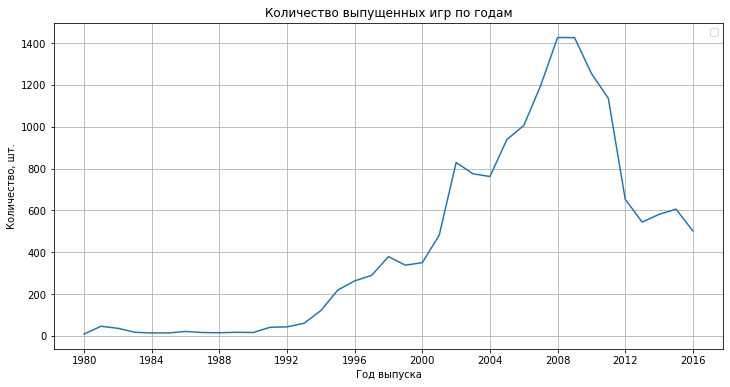

In [36]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=count_games_year)
plt.title('Количество выпущенных игр по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Количество, шт.')
plt.legend('')
plt.grid()
plt.show()

**Выводы:**

С начала 90-х годов и вплоть до 2010 года наблюдается бурный рост количества игр для игровых приставок и компьютера. С 1990 г. по 1994 г. количество игр выросло на порядок, а к 2009 г., в пике своего развития, уже на два порядка! С 2010 года, скорее всего из-за появления смартфонов (в которых необходимый для игр функционал очень быстро растёт), количество игр для игровых платформ и компьютеров стремительно снижается, а к 2016 году и вовсе оказывается на уровне 2001.

### Посмотрим, как менялись продажи по платформам.

Выберем платформы с наибольшими суммарными продажами:

In [37]:
best_sales_platform = (
    pd.DataFrame(
        df.groupby('platform')['total_sales'].sum()
    ).sort_values(by='total_sales', ascending=False)
)
# best_sales_platform

Построим распределение по платформам за всё время:

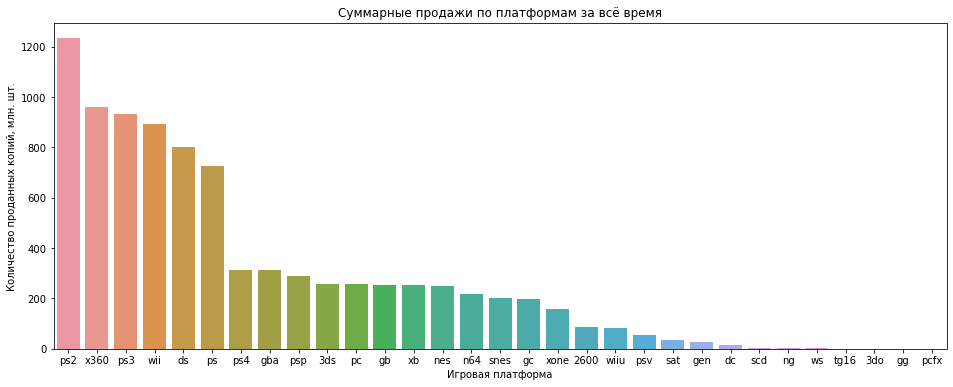

In [38]:
plt.figure(figsize=(16, 6))
sns.barplot(x=best_sales_platform.index, y=best_sales_platform['total_sales'])
plt.title('Суммарные продажи по платформам за всё время')
plt.xlabel('Игровая платформа')
plt.ylabel('Количество проданных копий, млн. шт.')
plt.show()

In [39]:
best_sales_platform = best_sales_platform[:5]
best_sales_platform

total_sales
platform             
ps2       1233.559937
x360       961.239990
ps3        931.339966
wii        891.179993
ds         802.780029

Шесть платформ ps2, x360, ps3, wii, ds и ps оказались самыми популярными за всё время.

**За какой характерный срок появляются новые и исчезают старые платформы?**
- возьмём данные за соответствующий **актуальный период**. Актуальный период определим самостоятельно в результате исследования. Основной фактор — эти данные помогут построить прогноз на 2017 год;
- не учитываем в работе данные за **предыдущие годы**.

Согласно информации сайта Википедии, поддержка платформ производителями:

**Sony PlayStation 2**, https://ru.wikipedia.org/wiki/PlayStation_2
- 04.03.2000 - 04.01.2013 (13 лет)

**Microsoft Xbox 360**, https://ru.wikipedia.org/wiki/Xbox_360
- 22.11.2005 - 20.04.2016 (10 лет)

**Sony PlayStation 3**, https://ru.wikipedia.org/wiki/PlayStation_3
- 11.11.2006 - н.в. (10 лет)

**Nintendo Wii**, https://ru.wikipedia.org/wiki/Wii
- 19.11.2006 - 20.10.2013 (7 лет)

**Nintendo DS**, https://ru.wikipedia.org/wiki/Nintendo_DS
- 21.11.2004 - 31.08.2013 (8 лет)

**Sony PlayStation**, https://ru.wikipedia.org/wiki/PlayStation
- 03.12.1994 - 23.03.2006 (11 лет)

Среднее время (лет) поддержки топ платформ производителями:

In [40]:
from datetime import date
ps2 = (date(2013, 1, 4) - date(2000, 3, 4)).days
x360 = (date(2016, 4, 20) - date(2005, 11, 22)).days
ps3 = (date(2017, 5, 29) - date(2006, 11, 11)).days
wii = (date(2013, 10, 20) - date(2006, 11, 19)).days
ds = (date(2013, 8, 31) - date(2004, 11, 21)).days
ps = (date(2006, 3, 23) - date(1994, 12, 3)).days
round(np.mean([ps2,x360,ps3,wii,ds,ps])/365)

10

Среднее время жизни (лет) этих топ платформ (количество лет, за которые продажи по годам были выше 10% от самого лучшего года по каждой платформе):

In [41]:
cgp = pd.DataFrame(columns={'platform', 'lifetime'})
koef = 0.1
for platform in best_sales_platform.index:
    count_games_platform = pd.DataFrame(df[df['platform'] == platform].groupby('year_of_release')['name'].count())
    threshold = round(count_games_platform['name'].max() * koef)
    lifetime = count_games_platform[ count_games_platform['name'] > threshold ].shape[0]
    cgp = pd.concat([cgp, pd.DataFrame(data={'platform':[platform], 'lifetime':[lifetime]})], ignore_index=False)
    
cgp.reset_index(drop=True, inplace=True)
round(cgp['lifetime'].mean())

9

Период существования игровой платформы и период основных продаж игр очень близки - 10 лет и 9 лет соответственно.

**Какие платформы лидируют по продажам, растут или падают?**

Построим датасет самых продаваемых платформ: ps2, x360, ps3, wii и ds за период с 2006 г. по 2016 г.

In [42]:
bsp = df[(df['year_of_release'] > '2005-01-01') & (df['platform'].isin(best_sales_platform.index))]

Построим графики количества продаж по самым продаваемым платформам за период с 2006 г. по 2016 г.:

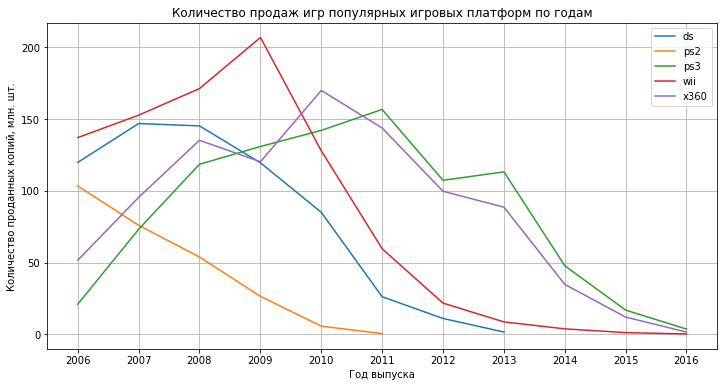

platform                 ds         ps2         ps3         wii        x360
year_of_release                                                            
2006-01-01       119.809998  103.419998   20.960001  137.149994   51.619999
2007-01-01       146.940002   75.989998   73.190002  152.770004   95.409996
2008-01-01       145.309998   53.900002  118.519997  171.320007  135.259995
2009-01-01       119.540001   26.400000  130.930008  206.970001  120.290001
2010-01-01        85.019997    5.640000  142.169998  127.949997  170.029999
2011-01-01        26.180000    0.450000  156.779999   59.649998  143.839996
2012-01-01        11.010000         NaN  107.360001   21.710001   99.739998
2013-01-01         1.540000         NaN  113.250000    8.590000   88.580002
2014-01-01              NaN         NaN   47.759998    3.750000   34.740002
2015-01-01              NaN         NaN   16.820000    1.140000   11.960000
2016-01-01              NaN         NaN    3.600000    0.180000    1.520000

In [43]:
t = pd.pivot_table(bsp,
    index=['year_of_release'],
    columns='platform',
    values='total_sales',
    aggfunc='sum'
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=t, dashes=False)
plt.legend()
plt.title('Количество продаж игр популярных игровых платформ по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Количество проданных копий, млн. шт.')
plt.grid()
plt.show()
display(t)

Самые продаваемые за 10 лет игровые платформы: ps2, x360, ps3, wii и ds уже заканчивают свой жизненный цикл к 2016 г. и уже не могут быть интересными в 2017 г. Однако, именно по ним ясно видно, что **наибольший интерес представляют данные за период**, на котором игровые платформы находятся в пике своей популярности, а именно **3 года**.

Построим датасет и графики количества продаж по игровым платформам за **актуальный период 2013 - 2016 гг.**:

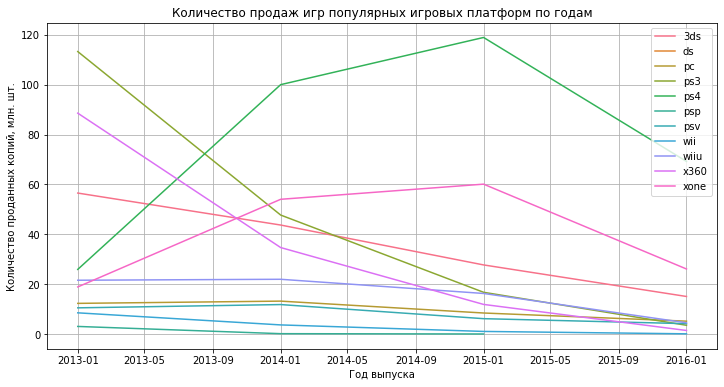

total_sales
platform             
ps4        314.140015
ps3        181.429993
xone       159.320007
3ds        143.250000
x360       136.800003
wiiu        64.629997
pc          39.430000
psv         32.989998
wii         13.660000
psp          3.500000

In [44]:
ap = df[df['year_of_release']>'2012-01-01']

t = pd.pivot_table(ap,
    index=['year_of_release'],
    columns='platform',
    values='total_sales',
    aggfunc='sum'
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=t, dashes=False)
plt.legend()
plt.title('Количество продаж игр популярных игровых платформ по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Количество проданных копий, млн. шт.')
plt.grid()
plt.show()

pd.DataFrame(
    ap.groupby('platform')['total_sales'].sum()
).sort_values(by='total_sales', ascending=False).head(10)

Согласно информации сайта Википедии, поддержка платформ производителями:

**Sony PlayStation 4**, https://ru.wikipedia.org/wiki/PlayStation_4
- 15.11.2013 - н.в. (поддержка прекращена 05.01.2021, но считаем, что сейчас начало 2016 года)

**Sony PlayStation 3**, https://ru.wikipedia.org/wiki/PlayStation_3
- 11.11.2006 - н.в. (поддержка прекращена 29.05.2017, но считаем, что сейчас начало 2016 года)

**Microsoft Xbox One**, https://ru.wikipedia.org/wiki/Xbox_One
- 22.11.2013 - н.в. (поддержка прекращена 2020 г., но считаем, что сейчас начало 2016 года)

**Nintendo 3DS**, https://ru.wikipedia.org/wiki/Nintendo_3DS
- 26.02.2011 - н.в. (поддержка прекращена 17.09.2020, но считаем, что сейчас начало 2016 года)

**Microsoft Xbox 360**, https://ru.wikipedia.org/wiki/Xbox_360
- 22.11.2005 - 20.04.2016 (10 лет)

**Nintendo Wii U**, https://ru.wikipedia.org/wiki/Wii_U
- 18.11.2012 - н.в. (поддержка прекращена 31.01.2017, но считаем, что сейчас начало 2016 года)

Для игровой платформы Microsoft Xbox 360 поддержка прекращена в 2016 г. Платформы Sony PlayStation 3, Nintendo Wii U и Nintendo 3DS находятся в стадии заката и их продажи стабильно сходят на нет.

Платформы Sony PlayStation 4 и Microsoft Xbox One актуальны и фактически в ближайший 2017 год будут делить рынок по продажам между собой. Обе платформы вышли в ноябре 2013 года и как раз в 2017 г. будут находится на пике своей популярности.

У остальных платформ продаж сильно меньше.

**Выводы:**

Период существования игровой платформы и период основных продаж игр равны и составляют 10 лет. Наибольшие продажи приходятся на 4-5 год с момента выпуска игровой платформы. Самые продаваемые за 10 лет игровые платформы: ps2, x360, ps3, wii и ds уже заканчивают свой жизненный цикл к 2016 г., как следствие уже не могут быть интересными в 2017 г. Однако, именно по ним ясно видно, что **наибольший интерес представляют данные за актуальный период**, на котором игровые платформы находятся в пике своей популярности, а именно **3 года**.


Игровые платформы `Sony PlayStation 4` и `Microsoft Xbox One` актуальны, а в 2017 г. будут находится на пике своей популярности, при этом делить фактически только между собой рынок.

### Построим график «ящик с усами» по глобальным продажам копий игр в разбивке по платформам.

Как выяснили актуальными являются платформы PS4 и Xbox One, поэтому выделим информацию по ним в отдельный датафрейм:

In [45]:
ap = df[(df['platform']=='ps4') | (df['platform']=='xone')]

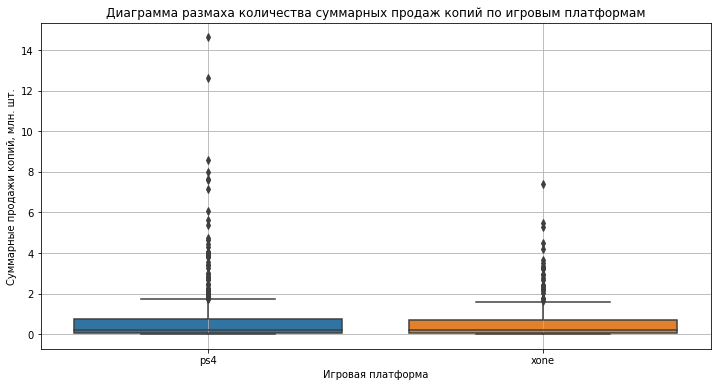

In [46]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=ap, x='platform', y='total_sales')
plt.title('Диаграмма размаха количества суммарных продаж копий по игровым платформам')
plt.xlabel('Игровая платформа')
plt.ylabel('Суммарные продажи копий, млн. шт.')
plt.grid()
plt.show()

Для изучения явно требуется разбиения на группы или изменение масштаба.

Построим гистограмму количества проданных копий игр:

<AxesSubplot:>

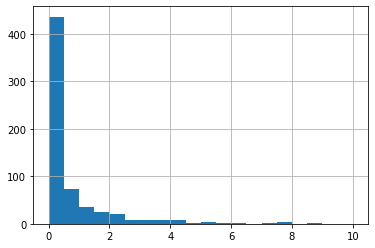

In [47]:
ap['total_sales'].hist(bins=20, range=(0,10))

In [48]:
ap.sort_values(by='total_sales', ascending=False).head()

name platform year_of_release    genre  \
31       call of duty: black ops 3      ps4      2015-01-01  shooter   
42              grand theft auto v      ps4      2014-01-01   action   
77                         fifa 16      ps4      2015-01-01   sports   
87    star wars battlefront (2015)      ps4      2015-01-01  shooter   
92  call of duty: advanced warfare      ps4      2014-01-01  shooter   

    na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
31      6.03      5.86      0.36         2.38           NaN         NaN   
42      3.96      6.31      0.38         1.97          97.0         8.3   
77      1.12      6.12      0.06         1.28          82.0         4.3   
87      2.99      3.49      0.22         1.28           NaN         NaN   
92      2.81      3.48      0.14         1.23          83.0         5.7   

   rating  total_sales  
31     rp    14.630000  
42      m    12.620001  
77      e     8.580000  
87     rp     7.980000  
92      m     7.660000

Все игры можно разделить на две группы:
- группа 1 - небольшое число игр проданных в огромном количестве копий;
- группа 2 - много игр проданных в малом количестве копий.

Критерием деления на группы будет порог - количество проданных копий (млн. шт.):

In [49]:
threshold = 2.1

**Для всех игр (группа 1 + группа 2).**

In [50]:
g = (
    ap.groupby(['platform'])['total_sales']
    .agg(['sum', 'count'])
    .rename(columns={'sum':'total_sales', 'count':'count'})
    .sort_values(by='total_sales', ascending=False)
)

**Группа 1 - много игр, проданных в малом количестве копий.**

In [51]:
ap1 = ap[ap['total_sales']<threshold]
g1 = (
    ap1.groupby(['platform'])['total_sales'].agg(['sum', 'count'])
    .rename(columns={'sum':'ts_g1', 'count':'count_g1'})
    .sort_values(by='ts_g1', ascending=False)
)

**Группа 2 - мало игр, проданных в большом количестве копий.**

In [52]:
ap2 = ap[ap['total_sales']>=threshold]
g2 = (
    ap2.groupby(['platform'])['total_sales'].agg(['sum', 'count'])
    .rename(columns={'sum':'ts_g2', 'count':'count_g2'})
    .sort_values(by='ts_g2', ascending=False)
)

Сводная таблица:

In [53]:
G = g.merge(g1, on=g.index)
G = G.merge(g2, left_on='key_0', right_on=g2.index).rename(columns={'key_0':'platform'})
G

platform  total_sales  count       ts_g1  count_g1       ts_g2  count_g2
0      ps4   314.140015    392  128.130005       351  186.009995        41
1     xone   159.320007    247   82.699997       224   76.620003        23

Процент количества игр из группы 1 от всего количества игр:

In [54]:
round(G['count_g1'].sum() / G['count'].sum() * 100, 1)

90.0

Процент проданных копий игр из группы 1 от всего количества игр:

In [55]:
round(G['ts_g1'].sum() / G['total_sales'].sum() * 100, 1)

44.5

Построим диаграмму размаха (график 'Ящик с усами') по суммарным продажам копий игр в разбивке по платформам (Группа 1 и 2).

In [56]:
G['avg_g1'] = round(G['ts_g1']/G['count_g1'],2)
G

platform  total_sales  count       ts_g1  count_g1       ts_g2  count_g2  \
0      ps4   314.140015    392  128.130005       351  186.009995        41   
1     xone   159.320007    247   82.699997       224   76.620003        23   

   avg_g1  
0    0.37  
1    0.37

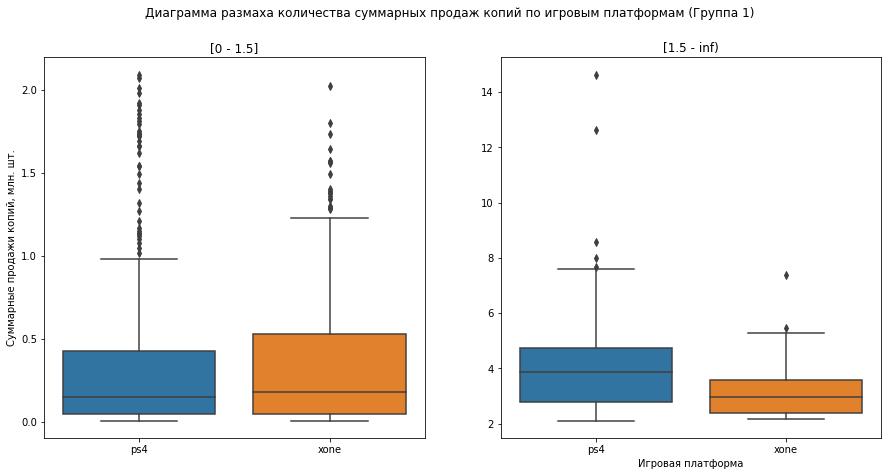

0.16 3.4


In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True)
fig.suptitle('Диаграмма размаха количества суммарных продаж копий по игровым платформам (Группа 1)')

sns.boxplot(data=ap1, x='platform', y='total_sales', ax=axes[0])
axes[0].set_title('[0 - 1.5]')
axes[0].set_xlabel('')
axes[0].set_ylabel('Суммарные продажи копий, млн. шт.')

sns.boxplot(data=ap2, x='platform', y='total_sales', ax=axes[1])
axes[1].set_title('[1.5 - inf)')
axes[1].set_xlabel('Игровая платформа')
axes[1].set_ylabel('')

plt.show()
print(round(ap1['total_sales'].median(),2), round(ap2['total_sales'].median(),2))

**Выводы:**

На первом графике приведена диаграмма размаха, построенная для 90% игр диапазона продаж [0 - 2.1] млн. копий (44.5% продаж). Половина продаж этих игр разошлась тиражом примерно 0.1-0.5 млн. копий, медиана 0.16 млн. шт.

На втором графике приведена диаграмма размаха, построенная для 10% игр диапазона продаж [2.1 - inf] млн. копий (55.5% продаж). Половина продаж этих игр разошлась тиражом примерно 2.5-5 млн. копий, медиана 3.40 млн. шт.

### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построем диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируем выводы;

*Принятые в работе уровни корреляций:*
- отсутствует: 0 - 0.1
- очень слабая: 0.1 - 0.3
- слабая: 0.3 - 0.5
- умеренная: 0.5 - 0.8
- сильная: 0.8 - 0.9
- очень сильная: 0.9 - 1.0

Отберем данные, касающиеся игровой платформы Sony PlayStation 4:

In [58]:
ps4 = ap[ap['platform']=='ps4']
# ps4.head()

Посчитаем корреляцию между оценками пользователей / критиков и суммарными продажами:

In [59]:
corr_u_ts = round(ps4['user_score'].corr(ps4['total_sales']), 2)
corr_c_ts = round(ps4['critic_score'].corr(ps4['total_sales']), 2)
print(f'Корреляция между оценками пользователей / критиков и суммарными продажами: {corr_u_ts} / {corr_c_ts}')

Корреляция между оценками пользователей / критиков и суммарными продажами: -0.03 / 0.41


Построим диаграммы рассеяния по оценке пользователей / критиков и суммарными продажами:

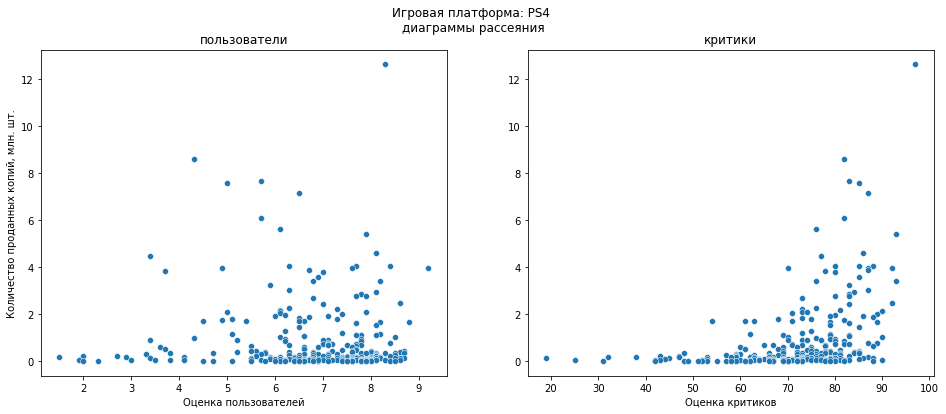

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=False, sharey=False)
fig.suptitle('Игровая платформа: PS4 \nдиаграммы рассеяния')

sns.scatterplot(data=ps4, x='user_score', y='total_sales', ax=axes[0])
axes[0].set_title('пользователи')
axes[0].set_xlabel('Оценка пользователей')
axes[0].set_ylabel('Количество проданных копий, млн. шт.')

sns.scatterplot(data=ps4, x='critic_score', y='total_sales', ax=axes[1])
axes[1].set_title('критики')
axes[1].set_xlabel('Оценка критиков')
axes[1].set_ylabel('')

plt.show()

In [61]:
corr_u_c_ts = best_sales_platform
corr_u_c_ts.loc[corr_u_c_ts.index=='ps4', 'users'] = corr_u_ts
corr_u_c_ts.loc[corr_u_c_ts.index=='ps4', 'critics'] = corr_c_ts
corr_u_c_ts = corr_u_c_ts[['users', 'critics']]

**Выводы:**

Корреляция между оценками:
- пользователей и суммарными продажами очень слабая отрицательная (-0.13);
- критиков и суммарными продажами слабая (0.41).

Вероятно покупатели больше склонны доверять критикам нежели пользователям.

Диаграммы рассеяния пользователей и критиков очень похожи и в целом отражают то, что чем выше оценка пользователя/критика, тем больше продано копий.

### Соотнесем выводы с продажами игр на других платформах;

Отберем данные, касающиеся игровой платформы Microsoft Xbox One:

In [62]:
xone = ap[ap['platform']=='xone']
# xone.head()

Посчитаем корреляцию между оценками пользователей / критиков и суммарными продажами:

In [63]:
corr_u_ts = round(xone['user_score'].corr(xone['total_sales']), 2)
corr_c_ts = round(xone['critic_score'].corr(xone['total_sales']), 2)
print(f'Корреляция между оценками пользователей / критиков и суммарными продажами: {corr_u_ts} / {corr_c_ts}')

Корреляция между оценками пользователей / критиков и суммарными продажами: -0.07 / 0.42


Построим диаграммы рассеяния по оценке пользователей / критиков и суммарными продажами:

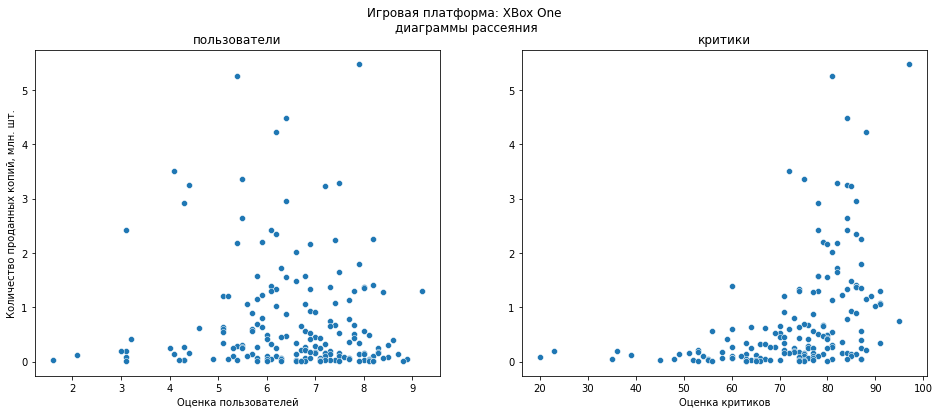

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=False, sharey=False)
fig.suptitle('Игровая платформа: XBox One \nдиаграммы рассеяния')

sns.scatterplot(data=xone, x='user_score', y='total_sales', ax=axes[0])
axes[0].set_title('пользователи')
axes[0].set_xlabel('Оценка пользователей')
axes[0].set_ylabel('Количество проданных копий, млн. шт.')

sns.scatterplot(data=xone, x='critic_score', y='total_sales', ax=axes[1])
axes[1].set_title('критики')
axes[1].set_xlabel('Оценка критиков')
axes[1].set_ylabel('')

plt.show()

**Выводы:**

Ситуация аналогичная платформе PS4.

Корреляция между оценками:
- пользователей и суммарными продажами очень слабая отрицательная (-0.07);
- критиков и суммарными продажами слабая (0.42).

Вероятно покупатели больше склонны доверять критикам нежели пользователям.

Диаграммы рассеяния пользователей и критиков очень похожи и в целом отражают то, что чем выше оценка пользователя/критика, тем больше продано копий.

### Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Общее распределение игр по жанрам за всё время по актуальным платформам:

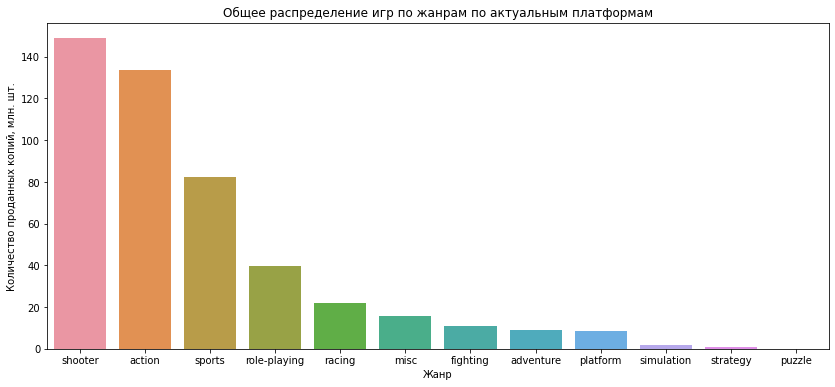

genre  total_sales  count_games  ts_median
0       shooter   148.889999           79      1.060
1        action   133.410004          229      0.150
2        sports    82.349998           84      0.415
3  role-playing    39.540001           65      0.200
4        racing    21.930000           39      0.230

In [65]:
df_genre = (
    ap.groupby('genre')
    .agg({'total_sales':'sum', 'name':'count'})
    .rename(columns={'name':'count_games'})
    .sort_values(by='total_sales', ascending=False)
    .reset_index()
    .merge(ap.groupby('genre')['total_sales'].median().reset_index().rename(columns={'total_sales':'ts_median'}))
)
plt.figure(figsize=(14, 6))
sns.barplot(x=df_genre['genre'], y=df_genre['total_sales'], order=df_genre['genre'])
plt.title('Общее распределение игр по жанрам по актуальным платформам')
plt.xlabel('Жанр')
plt.ylabel('Количество проданных копий, млн. шт.')
plt.show()

display(df_genre.head())

Общее распределение игр по жанрам по самым продаваемым (но уже не актуальным) платформам:

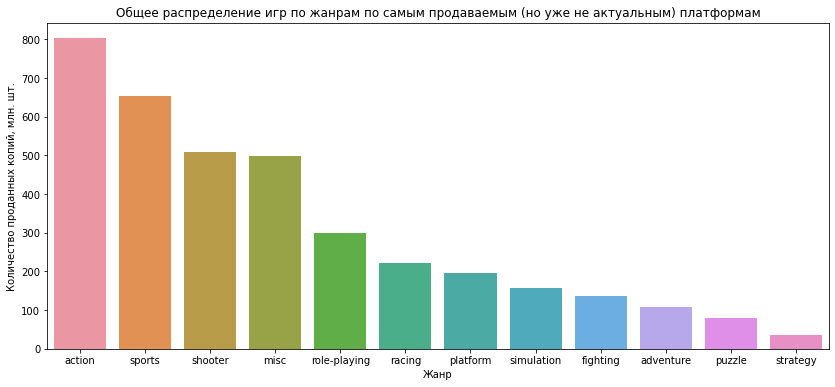

genre  total_sales  count_games  ts_median
0        action   802.549988         1359       0.24
1        sports   653.359985          938       0.22
2       shooter   508.820007          475       0.34
3          misc   497.700012          994       0.15
4  role-playing   299.429993          480       0.20

In [66]:
bsp_genre = (
    bsp.groupby('genre')
    .agg({'total_sales':'sum', 'name':'count'})
    .rename(columns={'name':'count_games'})
    .sort_values(by='total_sales', ascending=False)
    .reset_index()
    .merge(bsp.groupby('genre')['total_sales'].median().reset_index().rename(columns={'total_sales':'ts_median'}))
)
plt.figure(figsize=(14, 6))
sns.barplot(x=bsp_genre['genre'], y=bsp_genre['total_sales'], order=bsp_genre['genre'])
plt.title('Общее распределение игр по жанрам по самым продаваемым (но уже не актуальным) платформам')
plt.xlabel('Жанр')
plt.ylabel('Количество проданных копий, млн. шт.')
plt.show()

display(bsp_genre.head())

**Выводы:**

Для популярных платфор (но уже не актуальных) за минувшее десятилетие самыми продаваемыми жанрами являлись экшн - `action` (медиана 0.24), спорт - `sports` (медиана 0.22) и шутеры - `shooter` (медиана 0.34), аутсайдер: стратегии - `strategy`.

Для актуальных платформ PS4 и XBox One изменился порядок самых продаваемых жанров: ими стали шутеры - `shooter` (медиана 1.06), экшн - `action` (медиана 0.15) и спорт - `sports` (0.415), аутсайдер: пазл - `puzzle`.

Рост медианы говорит о том, что игр становится меньше, но продаются они большими тиражами.

<div class="alert alert-block alert-info"><b>Выводы по разделу:</b><br>
    
С начала 90-х годов и вплоть до 2010 года наблюдается бурный рост количества игр для игровых приставок и компьютера. С 1990 г. по 1994 г. количество игр выросло на порядок, а к 2009 г., в пике своего развития, уже на два порядка! С 2010 года, скорее всего из-за появления смартфонов, количество игр для игровых платформ и компьютеров стремительно снижается, а к 2016 году и вовсе оказывается на уровне 2001.

Также выявлено, что период существования игровой платформы и период основных продаж игр равны и составляют 10 лет. Наибольшие продажи приходятся на 4-5 год с момента выпуска игровой платформы. Самые продаваемые за 10 лет игровые платформы: ps2, x360, ps3, wii и ds уже заканчивают свой жизненный цикл к 2016 г., как следствие уже не могут быть интересными в 2017 г. Однако, именно по ним ясно видно, что **наибольший интерес представляют данные за актуальный период**, на котором игровые платформы находятся в пике своей популярности, а именно **3 года**. Игровые платформы Sony PlayStation 4 и Microsoft Xbox One актуальны, а в 2017 г. будут находится на пике своей популярности, при этом делить фактически только между собой рынок.

На 10% игр приходится чуть больше половины продаж.

Анализ оценок пользователей и критиков показал взаимосвязь с продажами игр: чем выше оценка, тем более вероятны бОльшие объёмы продаж. При этом, покупатели больше склонны доверять критикам нежели пользователям.

Для актуальных платформ PS4 и XBox One самые продаваемые жанры стали шутеры - `shooter`, экшн - `action` и спорт - `sports`, аутсайдер: пазл - `puzzle`. Игр становится меньше, но продаются они большими тиражами.
</div>

## Портрет пользователя каждого региона
- определим для пользователя каждого региона (NA, EU, JP):
    - самые популярные платформы (топ-5). Опишем различия в долях продаж;
    - самые популярные жанры (топ-5). Поясним разницу;
    - влияет ли рейтинг ESRB на продажи в отдельном регионе?

**Справочная информация:**

Информация на русском языке по устройству ESRB доступна по ссылке:
https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board

- «EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими.
- «E» («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет.
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше».
- «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет.
- «M» («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет.
- «AO» («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет.
- «RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга.
- «RP 17+» («Rating Pending») — «Рейтинг ожидается - примерно 17+».

Самые популярные платформы (топ-5). Опишем различия в долях продаж.

In [67]:
# year = 0, за всё время
# year = '2013-01-01', только за актуальный период с 2013 по 2016 включительно.
def df_user(column, region, year):
    if year != 0: df1 = df[df['year_of_release']>=year]
    else: df1 = df
    
    bsp = (
        df1.groupby(column)
        .agg({region:'sum'})
        .sort_values(by=region, ascending=False)
    )
    bsp['perc'] = round(bsp[region] / bsp[region].sum() * 100, 2)
    return bsp.head(5)

In [68]:
def df_user_char(region, year):
    fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=False, sharey=False)
    fig.suptitle(f'Суммарные продажи')
    for i, column in enumerate(columns):
        sns.barplot(data=df_user(column, region, year),
                    x=df_user(column, region, year).index,
                    y=df_user(column, region, year)['perc'],
                    order=df_user(column, region, year).index,
                    ax=axes[i])
        if column == 'platform':
            axes[i].set_title('по платформам')
            axes[i].set_xlabel('Игровая платформа')
            axes[i].set_ylabel('Количество проданных копий, %')
        elif column == 'genre':
            axes[i].set_title('по жанрам')
            axes[i].set_xlabel('Жанры')
            axes[i].set_ylabel('')
        elif column == 'rating':
            axes[i].set_title('по рейтингу')
            axes[i].set_xlabel('Рейтинг')
            axes[i].set_ylabel('')
    plt.show()

In [69]:
columns = ['platform', 'genre', 'rating']

### Портрет пользователя North America

За всё время:

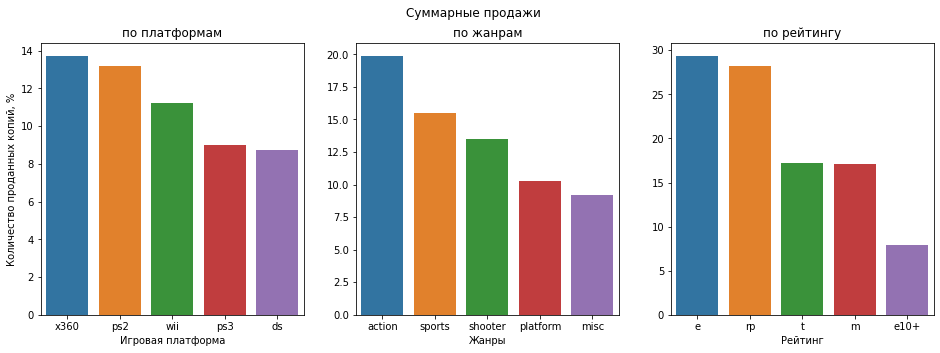

na_sales   perc
platform                   
x360      595.739990  13.72
ps2       572.919983  13.20
wii       486.869995  11.21
ps3       390.130005   8.99
ds        380.309998   8.76

na_sales       perc
genre                          
action    863.169983  19.879999
sports    671.200012  15.460000
shooter   584.830017  13.470000
platform  444.440002  10.240000
misc      399.570007   9.200000

na_sales       perc
rating                        
e       1274.239990  29.350000
rp      1225.839966  28.240000
t        747.599976  17.219999
m        742.890015  17.110001
e10+     345.500000   7.960000

In [70]:
region = 'na_sales'
year = 0
df_user_char(region, year)
for column in columns:
    display(df_user(column, region, year))

- популярность игровых платформ по убыванию: X360, PS2, WII, PS3, DS;
- топ 5 жанров по убыванию: action, sports, shooter, platform, misc;
- игры с рейтингом `e` (для всех) лидируют, практически столько же игр с рейтингом `rp` — продукт был отправлен в ESRB и ожидает присвоения рейтинга, далее следуют игры с рейтингом `t` (подросткам, от 13 лет) и `m` (для взрослых, от 17 лет).

Только за актуальный период 2013 - 2016:

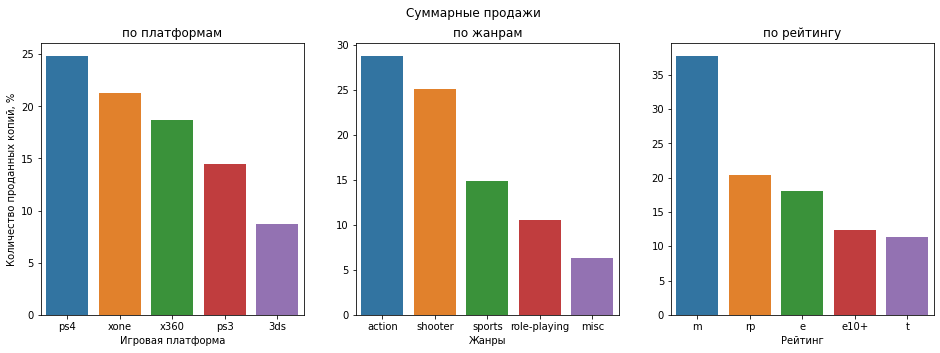

na_sales   perc
platform                   
ps4       108.739998  24.84
xone       93.120003  21.27
x360       81.659996  18.66
ps3        63.500000  14.51
3ds        38.200001   8.73

na_sales       perc
genre                              
action        126.050003  28.799999
shooter       109.739998  25.070000
sports         65.269997  14.910000
role-playing   46.400002  10.600000
misc           27.490000   6.280000

na_sales       perc
rating                       
m       165.210007  37.740002
rp       89.419998  20.430000
e        79.050003  18.059999
e10+     54.240002  12.390000
t        49.790001  11.380000

In [71]:
region = 'na_sales'
year = '2013-01-01'
df_user_char(region, year)
for column in columns:
    display(df_user(column, region, year))

- популярность игровых платформ по убыванию: PS4, Xbox One, X360, PS3, 3DS;
- топ 5 жанров по убыванию: action, shooter, sports, role-playing, misc;
- игры с рейтингом `m` (для взрослых, от 17 лет) лидируют, далее игры с рейтингом `rp` — продукт был отправлен в ESRB и ожидает присвоения рейтинга, потом игры с рейтингом `e` (для всех) и `e10+` (от 10 лет).

### Портрет пользователя Europe

За всё время:

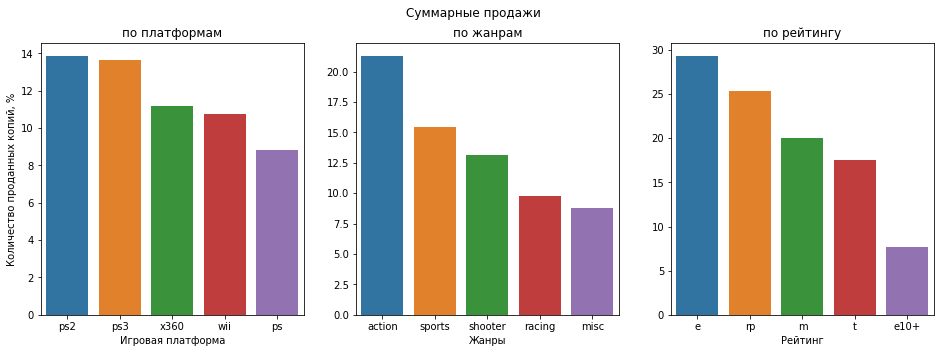

eu_sales   perc
platform                   
ps2       332.630005  13.86
ps3       327.209991  13.64
x360      268.320007  11.18
wii       258.320007  10.76
ps        212.389999   8.85

eu_sales       perc
genre                         
action   510.989990  21.290001
sports   371.329987  15.470000
shooter  314.519989  13.110000
racing   234.490005   9.770000
misc     210.600006   8.780000

eu_sales   perc
rating                   
e       703.869995  29.33
rp      609.679993  25.41
m       480.000000  20.00
t       421.790009  17.58
e10+    183.350006   7.64

In [72]:
region = 'eu_sales'
year = 0
df_user_char(region, year)
for column in columns:
    display(df_user(column, region, year))

- популярность игровых платформ по убыванию: PS2, PS3, X360, WII, PS;
- топ 5 жанров по убыванию: action, sports, shooter, racing, misc;
- игры с рейтингом `e` (для всех) лидируют, практически столько же игр с рейтингом `rp` — продукт был отправлен в ESRB и ожидает присвоения рейтинга, далее следуют игры с рейтингом `m` (для взрослых, от 17 лет) и `t` (подросткам, от 13 лет).

Только за актуальный период 2013 - 2016:

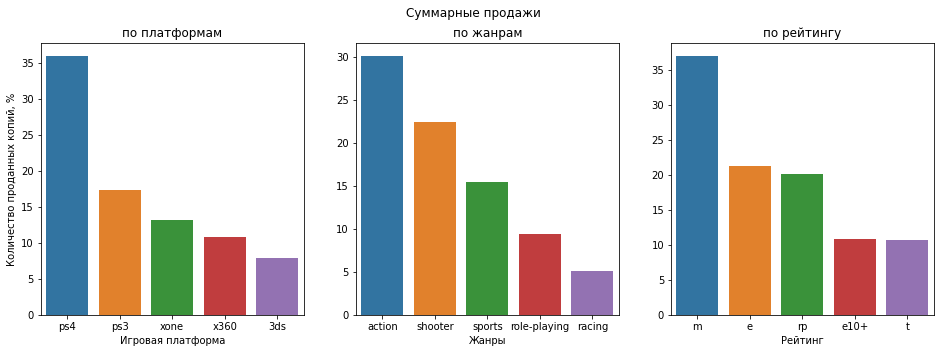

eu_sales       perc
platform                       
ps4       141.089996  35.970001
ps3        67.809998  17.290001
xone       51.590000  13.150000
x360       42.520000  10.840000
3ds        30.959999   7.890000

eu_sales       perc
genre                              
action        118.129997  30.120001
shooter        87.860001  22.400000
sports         60.520000  15.430000
role-playing   36.970001   9.430000
racing         20.190001   5.150000

eu_sales       perc
rating                       
m       145.320007  37.049999
e        83.360001  21.250000
rp       78.909996  20.120001
e10+     42.689999  10.880000
t        41.950001  10.700000

In [73]:
region = 'eu_sales'
year = '2013-01-01'
df_user_char(region, year)
for column in columns:
    display(df_user(column, region, year))

- популярность игровых платформ по убыванию: PS4, PS3, Xbox One, X360, 3DS;
- топ 5 жанров по убыванию: action, shooter, sports, role-playing, racing;
- игры с рейтингом `m` (для взрослых, от 17 лет) лидируют, далее игры с рейтингом `e` (для всех), потом `rp` — продукт был отправлен в ESRB и ожидает присвоения рейтинга и `e10+` (от 10 лет).

### Портрет пользователя Japan

За всё время:

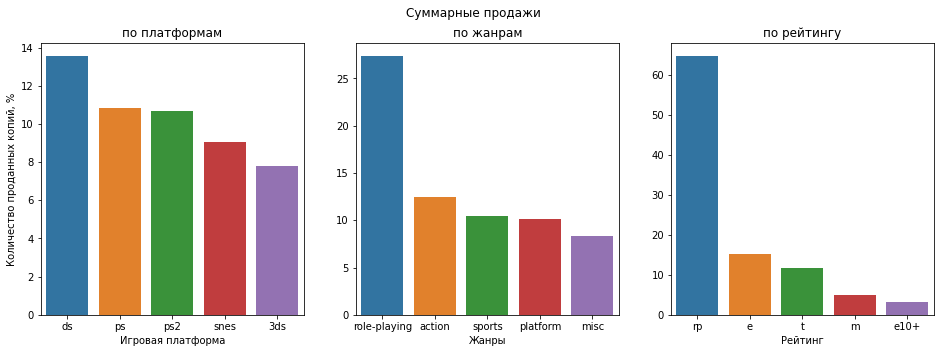

jp_sales   perc
platform                   
ds        175.020004  13.56
ps        139.779999  10.83
ps2       137.539993  10.66
snes      116.550003   9.03
3ds       100.620003   7.80

jp_sales       perc
genre                              
role-playing  353.390015  27.379999
action        160.139999  12.410000
sports        134.929993  10.450000
platform      130.710007  10.130000
misc          107.019997   8.290000

jp_sales       perc
rating                       
rp      836.739990  64.830002
e       197.960007  15.340000
t       150.699997  11.680000
m        63.579998   4.930000
e10+     40.200001   3.110000

In [74]:
region = 'jp_sales'
year = 0
df_user_char(region, year)
for column in columns:
    display(df_user(column, region, year))

- популярность игровых платформ по убыванию: DS, PS, PS2, SNES, 3DS;
- топ 5 жанров по убыванию: role-playing, action, sports, platform, misc;
- на первом месте игры с рейтингом `rp` — продукт был отправлен в ESRB и ожидает присвоения рейтинга, за ним игры с рейтингом `e` (для всех), потом игры с рейтингом `t` (подросткам, от 13 лет) и `m` (для взрослых, от 17 лет).

Только за актуальный период 2013 - 2016:

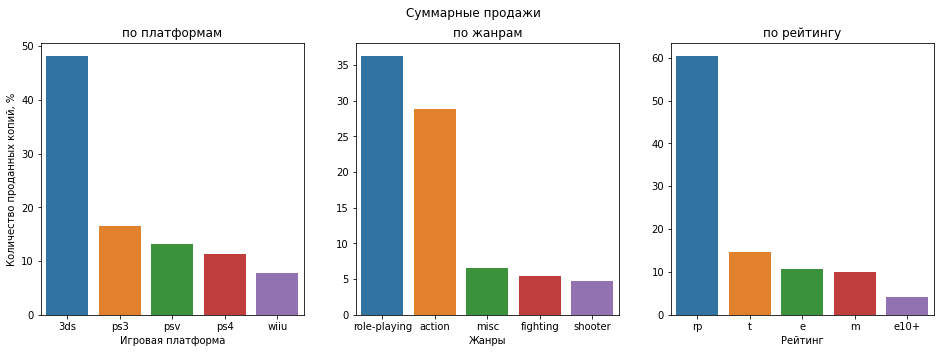

jp_sales       perc
platform                      
3ds       67.809998  48.169998
ps3       23.350000  16.590000
psv       18.590000  13.210000
ps4       15.960000  11.340000
wiiu      10.880000   7.730000

jp_sales       perc
genre                             
role-playing  51.040001  36.259998
action        40.490002  28.760000
misc           9.200000   6.540000
fighting       7.650000   5.430000
shooter        6.610000   4.700000

jp_sales   perc
rating                  
rp      85.050003  60.41
t       20.590000  14.63
e       15.140000  10.75
m       14.110000  10.02
e10+     5.890000   4.18

In [75]:
region = 'jp_sales'
year = '2013-01-01'
df_user_char(region, year)
for column in columns:
    display(df_user(column, region, year))

- популярность игровых платформ по убыванию: 3DS, PS3, PSV, PS4, Wii U;
- топ 5 жанров по убыванию: role-playing, action, misc, fighting, shooter;
- на первом месте игры с рейтингом `rp` — продукт был отправлен в ESRB и ожидает присвоения рейтинга, за ним игры с рейтингом `t` (подросткам, от 13 лет), потом `e` (для всех) и `m` (для взрослых, от 17 лет).

<div class="alert alert-block alert-info"><b>Выводы по разделу:</b><br>
Игровая индустрия весьма динамична в плане развития технологий и смены жанровых предпочтений пользователей, поэтому для прогноза ближайших будущих продаж (на 2017 год) интересен актуальный период последних лет: 2013 - 2016 гг. В Северной Америке и Европе предпочтения совпадаю, в Японии всё по-своему.
    
Северная Америка (NA):
- популярность игровых платформ по убыванию: PS4, Xbox One, X360, PS3, 3DS;
- топ 5 жанров по убыванию: action, shooter, sports, role-playing, misc;
- игры с рейтингом `m` (для взрослых, от 17 лет) лидируют, далее игры с рейтингом `rp` — продукт был отправлен в ESRB и ожидает присвоения рейтинга, потом игры с рейтингом `e` (для всех) и `e10+` (от 10 лет).

Европа (EU):
- популярность игровых платформ по убыванию: PS4, PS3, Xbox One, X360, 3DS;
- топ 5 жанров по убыванию: action, shooter, sports, role-playing, racing;
- игры с рейтингом `m` (для взрослых, от 17 лет) лидируют, далее игры с рейтингом `e` (для всех), потом `rp` — продукт был отправлен в ESRB и ожидает присвоения рейтинга и `e10+` (от 10 лет).

Япония (JP):
- популярность игровых платформ по убыванию: 3DS, PS3, PSV, PS4, Wii U;
- топ 5 жанров по убыванию: role-playing, action, misc, fighting, shooter;
- на первом месте игры с рейтингом `rp` — продукт был отправлен в ESRB и ожидает присвоения рейтинга, за ним игры с рейтингом `t` (подросткам, от 13 лет), потом `e` (для всех) и `m` (для взрослых, от 17 лет).



<i>Портреты пользователей по регионам NA, EU и JP за всё время скорее для справки и общего понимания картины изменений:
    NA
- популярность игровых платформ по убыванию: X360, PS2, WII, PS3, DS;
- топ 5 жанров по убыванию: action, sports, shooter, platform, misc;
- игры с рейтингом `e` (для всех) лидируют, практически столько же игр с рейтингом `rp` — продукт был отправлен в ESRB и ожидает присвоения рейтинга, далее следуют игры с рейтингом `t` (подросткам, от 13 лет) и `m` (для взрослых, от 17 лет).

    EU
- популярность игровых платформ по убыванию: PS2, PS3, X360, WII, PS;
- топ 5 жанров по убыванию: action, sports, shooter, racing, misc;
- игры с рейтингом `e` (для всех) лидируют, практически столько же игр с рейтингом `rp` — продукт был отправлен в ESRB и ожидает присвоения рейтинга, далее следуют игры с рейтингом `m` (для взрослых, от 17 лет) и `t` (подросткам, от 13 лет).

    JP
- популярность игровых платформ по убыванию: DS, PS, PS2, SNES, 3DS;
- топ 5 жанров по убыванию: role-playing, action, sports, platform, misc;
- на первом месте игры с рейтингом `rp` — продукт был отправлен в ESRB и ожидает присвоения рейтинга, за ним игры с рейтингом `e` (для всех), потом игры с рейтингом `t` (подросткам, от 13 лет) и `m` (для взрослых, от 17 лет).
</i>
</div>

## Проверим гипотезы
- средние пользовательские рейтинги платформ `Xbox One` и `PC` одинаковые;
- средние пользовательские рейтинги жанров `action` и `sports` (англ. «спортивные соревнования») разные;

Пороговое значение `alpha` зададим равным **0.05**.

Поясним:
- как сформулировали нулевую и альтернативную гипотезы;
- какой критерий применили для проверки гипотез и почему.

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые¶

Сформулируем гипотезы:

Нулевая гипотеза: средние пользовательские рейтинги платформ `Xbox One` и `PC` одинаковые.<br>
Альтернативная гипотеза: средние пользовательские рейтинги платформ `Xbox One` и `PC` различаются.

Согласно информации сайта Википедии, поддержка платформы `Xbox One` производителем:<br>
**`Microsoft Xbox One`**, https://ru.wikipedia.org/wiki/Xbox_One
- 22.11.2013 - 2020 (7 лет)

Соответственно период для `PC` возьмём тот же, что и для `Xbox One`, т.е. 2013 - 2016 гг.

Средний рейтинг пользователя для игровой платформы `XBox One`:

In [76]:
xone = df[df['platform']=='xone']['user_score']
xone = xone.dropna()
xone.mean()

6.521427154541016

Средний рейтинг пользователя для `PC`:

In [77]:
pc = df[(df['platform']=='pc') & (df['year_of_release'] > '2013-01-01')]['user_score']
pc = pc.dropna()
pc.mean()

6.298359394073486

Для проверки гипотезы используем метод `ttest_ind`:

In [78]:
alpha = .05

results = st.ttest_ind(xone, pc, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.22941186190442334
Не получилось отвергнуть нулевую гипотезу


Значение `p-value` примерно равно 0.23, что значительно больше уровня значимости альфа (0.05).<br>
Таким образом, не получилось отвергнуть нулевую гипотезу, а значит средние пользовательские рейтинги платформ `XBox One` и `PC` статистически не различаются.

### Средние пользовательские рейтинги жанров action и sports разные

Сформулируем гипотезы:

Нулевая гипотеза: средние пользовательские рейтинги жанров `action` и `sports` одинаковые.<br>
Альтернативная гипотеза: средние пользовательские рейтинги жанров `action` и `sports` различаются.

Проведем проверку за всё время и за последние 10 лет.

#### За всё время:

In [79]:
g_action = df[df['genre']=='action']['user_score']
g_action = g_action.dropna()
g_action.mean()

7.0581135749816895

In [80]:
g_sports = df[df['genre']=='sports']['user_score']
g_sports = g_sports.dropna()
g_sports.mean()

6.951431751251221

Для проверки гипотезы используем метод `ttest_ind`:

In [81]:
alpha = .05

results = st.ttest_ind(g_action, g_sports, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.07370127685470523
Не получилось отвергнуть нулевую гипотезу


Значение `p-value` примерно равно 0.07, что больше уровня значимости альфа (0.05).<br>
Таким образом, не получилось отвергнуть нулевую гипотезу, а значит средние пользовательские рейтинги жанров `action` и `sports` статистически не различаются.

#### За последние 10 лет:

In [82]:
g_action = df[(df['genre']=='action') & (df['year_of_release']>'2005-01-01')]['user_score']
g_action = g_action.dropna()
g_action.mean()

6.878613471984863

In [83]:
g_sports = df[(df['genre']=='sports') & (df['year_of_release']>'2005-01-01')]['user_score']
g_sports = g_sports.dropna()
g_sports.mean()

6.416419982910156

Для проверки гипотезы используем метод `ttest_ind`:

In [84]:
alpha = .05

results = st.ttest_ind(g_action, g_sports, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 5.318778032412661e-10
Отвергаем нулевую гипотезу


Значение `p-value` значительно меньше уровня значимости альфа (0.05).<br>
Таким образом, отвергаем нулевую гипотезу, а значит средние пользовательские рейтинги жанров `action` и `sports` статистически различаются.

#### За 2015 - 2016 гг.:

In [85]:
g_action = df[(df['genre']=='action') & (df['year_of_release']>'2014-01-01')]['user_score']
g_action = g_action.dropna()
g_action.mean()

g_sports = df[(df['genre']=='sports') & (df['year_of_release']>'2014-01-01')]['user_score']
g_sports = g_sports.dropna()
g_sports.mean()

alpha = .05
results = st.ttest_ind(g_action, g_sports, equal_var=False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 5.971647204081296e-10
Отвергаем нулевую гипотезу


Значение `p-value` значительно меньше уровня значимости альфа (0.05).<br>
Таким образом, отвергаем нулевую гипотезу, а значит средние пользовательские рейтинги жанров `action` и `sports` статистически различаются.

<div class="alert alert-block alert-info"><b>Выводы по разделу:</b><br><br>
За период 2013 - 2016 гг. (время одновременного существования игровой платформы Xbox One и PC) средние пользовательские рейтинги платформ Xbox One и PC статистически не различаются.

За всё время средние пользовательские рейтинги жанров action и sports статистически не различаются. Однако, если взять последние 10 лет или даже период 2015-2016 гг. ситуация меняется на противоположную: средние пользовательские рейтинги жанров action и sports статистически различаются.
</div>

## Общий вывод

Целью данной работы было выявить закономерности, определяющие успешность компьютерных игр, что необходимо для своевременного планирования рекламных кампаний потенциально популярных продуктов.

Были предоставлены исторические данные за период 1980 – 2015 гг. и частично за 2016 год о играх, их продажах с разбивкой по трём регионам `NA`, `EU` и `JP`, оценках пользователей и критиков, жанрах и игровых платформах (`Xbox`, `PlayStation`, `Wii` и т.д.). Загруженные данные были подготовлены для дальнейшего анализа.

С начала 90-х годов и вплоть до 2010 года наблюдается бурный рост количества игр для игровых приставок и компьютера. С 1990 г. по 1994 г. количество игр выросло на порядок, а к 2009 г., в пике своего развития, уже на два порядка! С 2010 года, скорее всего из-за появления смартфонов, количество игр для игровых платформ и компьютеров стремительно снижается, а к 2016 году и вовсе оказывается на уровне 2001.

Также выявлено, что период существования игровой платформы и период основных продаж игр равны и составляют 10 лет. Наибольшие продажи приходятся на 4-5 год с момента выпуска игровой платформы. Самые продаваемые за 10 лет игровые платформы: `ps2`, `x360`, `ps3`, `wii` и `ds` уже заканчивают свой жизненный цикл к 2016 г., как следствие уже не могут быть интересными в 2017 г. Однако, именно по ним ясно видно, что **наибольший интерес представляют данные за актуальный период**, на котором игровые платформы находятся в пике своей популярности, а именно **3 года**. Игровые платформы **`Sony PlayStation 4` и `Microsoft Xbox One` актуальны**, а в 2017 г. будут находится на пике своей популярности, при этом делить фактически только между собой рынок.

На 10% игр приходится чуть больше половины продаж.

Анализ оценок пользователей и критиков показал взаимосвязь с продажами игр: чем выше оценка, тем более вероятны бОльшие объёмы продаж. При этом, покупатели больше склонны доверять критикам нежели пользователям.

Для актуальных платформ `PS4` и `XBox One` самые продаваемые жанры стали шутеры - `shooter`, экшн - `action` и спорт - `sports`, аутсайдер: пазл - `puzzle`. Игр становится меньше, но продаются они большими тиражами.

Составили портреты пользователей по регионам. В Северной Америке (`NA`) и Европе (`EU`) предпочтения совпадают. Предпочитают играть на `PS4` в жанре `action` с рейтингом `m` (от 17 лет).
В Японии (`JP`) всё по-своему. Играют на платформе `3DS` в жанре `role-playing` с рейтингом `t`.

**Исходя из результатов исследования, в первую очередь нужно сделать упор на продажах игр для игровой платформ `Sony PlayStation 4` и `Microsoft Xbox One` в жанрах `shooter` и ` action` с рейтингом `m` (от 17 лет) для американского и европейского рынков.**